# Dataset obtained from:

https://www.mammaldiversity.org/


# How to build the hierarchy or the knowledge graph?

## Extract only the major ranks from the dataset: (Common Name, species, genus, family, order, subclass)

In [ ]:
import pandas as pd

df = pd.read_csv("/content/species.csv")

print(list(df.columns))


['sciName', 'id', 'phylosort', 'mainCommonName', 'otherCommonNames', 'subclass', 'infraclass', 'magnorder', 'superorder', 'order', 'suborder', 'infraorder', 'parvorder', 'superfamily', 'family', 'subfamily', 'tribe', 'genus', 'subgenus', 'specificEpithet', 'authoritySpeciesAuthor', 'authoritySpeciesYear', 'authorityParentheses', 'originalNameCombination', 'authoritySpeciesCitation', 'authoritySpeciesLink', 'typeVoucher', 'typeKind', 'typeVoucherURIs', 'typeLocality', 'typeLocalityLatitude', 'typeLocalityLongitude', 'nominalNames', 'subspecies', 'taxonomyNotes', 'taxonomyNotesCitation', 'distributionNotes', 'distributionNotesCitation', 'subregionDistribution', 'countryDistribution', 'continentDistribution', 'biogeographicRealm', 'iucnStatus', 'extinct', 'domestic', 'flagged', 'CMW_sciName', 'diffSinceCMW', 'MSW3_matchtype', 'MSW3_sciName', 'diffSinceMSW3']


In [ ]:
import pandas as pd

df = pd.read_csv("/content/species.csv")

# columns to keep
keep = [
    "mainCommonName",
    "sciName",
    "specificEpithet",
    "subgenus",
    "genus",
    "tribe",
    "subfamily",
    "family",
    "superfamily",
    "parvorder",
    "infraorder",
    "suborder",
    "order",
    "superorder",
    "magnorder",
    "infraclass",
    "subclass"
]

# rename columns
df_small = (
    df[keep]
      .drop_duplicates()
      .reset_index(drop=True)
      .rename(columns={
          "mainCommonName": "CommonName",
          "sciName": "Species",
          "specificEpithet":"SpecificEpithet",
          "subgenus": "Subgenus",
          "genus": "Genus",
          "tribe": "Tribe",
          "subfamily": "Subfamily",
          "family": "Family",
          "superfamily": "Superfamily",
          "parvorder": "Parvorder",
          "infraorder": "Infraorder",
          "suborder": "Suborder",
          "order": "Order",
          "superorder": "Superorder",
          "magnorder" : "Magnorder",
          'infraclass': "Infraclass",
          "subclass": "Subclass",
      })
)

# save
df_small.to_csv("/content/mammal_major_ranks.csv", index=False)


In [ ]:
print(df_small)

                              CommonName                   Species  \
0                               Platypus  Ornithorhynchus_anatinus   
1                   Short-beaked Echidna    Tachyglossus_aculeatus   
2     Attenborough's Long-beaked Echidna   Zaglossus_attenboroughi   
3            Eastern Long-beaked Echidna         Zaglossus_bartoni   
4            Western Long-beaked Echidna        Zaglossus_bruijnii   
...                                  ...                       ...   
6796                  Pygmy Beaked Whale     Mesoplodon_peruvianus   
6797            Stejneger's Beaked Whale     Mesoplodon_stejnegeri   
6798                 Spade-toothed Whale      Mesoplodon_traversii   
6799             Shepherd's Beaked Whale      Tasmacetus_shepherdi   
6800               Cuvier's Beaked Whale       Ziphius_cavirostris   

     SpecificEpithet Subgenus            Genus Tribe Subfamily  \
0           anatinus      NaN  Ornithorhynchus   NaN       NaN   
1          aculeatus      N

In [ ]:
import pandas as pd

columns = [
    "CommonName",
    "Species",
    "SpecificEpithet",
    "Subgenus",
    "Genus",
    "Tribe",
    "Subfamily",
    "Family",
    "Superfamily",
    "Parvorder",
    "Infraorder",
    "Suborder",
    "Order",
    "Superorder",
    "Magnorder",
    "Infraclass",
    "Subclass"
]

# Print number of unique values for each column, including column name
for col in columns:
    num_unique = df_small[col].nunique()
    print(f"# Column: {col}")
    print(f"Number of unique {col}: {num_unique}\n")


# Column: CommonName
Number of unique CommonName: 6801

# Column: Species
Number of unique Species: 6801

# Column: SpecificEpithet
Number of unique SpecificEpithet: 4778

# Column: Subgenus
Number of unique Subgenus: 180

# Column: Genus
Number of unique Genus: 1357

# Column: Tribe
Number of unique Tribe: 153

# Column: Subfamily
Number of unique Subfamily: 159

# Column: Family
Number of unique Family: 167

# Column: Superfamily
Number of unique Superfamily: 27

# Column: Parvorder
Number of unique Parvorder: 4

# Column: Infraorder
Number of unique Infraorder: 19

# Column: Suborder
Number of unique Suborder: 24

# Column: Order
Number of unique Order: 27

# Column: Superorder
Number of unique Superorder: 6

# Column: Magnorder
Number of unique Magnorder: 2

# Column: Infraclass
Number of unique Infraclass: 3

# Column: Subclass
Number of unique Subclass: 2



In [ ]:
# Print unique Subclasses
counts = df_small["Subclass"].value_counts(dropna=False)
print(counts)

Subclass
Theria        6796
Yinotheria       5
Name: count, dtype: int64


## Generate Embeddings (OpenAI text-embedding-3-large) - (embed species + commonName)

In [ ]:
import os, numpy as np
from tqdm import tqdm
from openai import OpenAI

In [ ]:
client = OpenAI(api_key="")

def get_openai_embeddings(texts, model="text-embedding-3-large", batch_size=96):
    all_embeds = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Embedding"):
        batch = texts[i : i + batch_size]

        response = client.embeddings.create(
            model=model,
            input=batch,
            encoding_format="float"
        )

        batch_sorted = sorted(response.data, key=lambda o: o.index)
        all_embeds.extend([item.embedding for item in batch_sorted])

    return np.asarray(all_embeds, dtype=np.float32)


In [ ]:
# embed species + commonName
df_small["text_for_embed"] = (
    df_small["Species"].str.replace("_", " ")
    + " | "
    + df_small["CommonName"]
)

texts = df_small["text_for_embed"].tolist()
emb   = get_openai_embeddings(texts)

print(emb.shape, emb.dtype)

Embedding: 100%|██████████| 71/71 [03:56<00:00,  3.33s/it]

(6801, 3072) float32


#KMeans k = 167 (Number of unique Family)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

km_final  = KMeans(n_clusters=167, n_init=30, random_state=42)
labels    = km_final.fit_predict(emb)
centroids = km_final.cluster_centers_

# Method from [LLMEdgeRefine: Enhancing Text Clustering with LLM-Based Boundary Point Refinement](https://aclanthology.org/2024.emnlp-main.1025/)

## SPEC: "Super-point Enhanced Clustering"
1) **Extract the farthest α% (e.g., 10%) from each cluster:** For each cluster, compute Euclidean distance between all points and their cluster centroid. Select the top α% farthest points (these are considered edge points or potential outliers).

2) **Form a super-point from each set of edge points:** For each cluster, average the embeddings of the selected edge points to form a single super-point vector. This acts as a dense representation of the "tail" of the cluster and reduces the influence of noise.

3) **Treat remaining (non-edge) points as singleton clusters**: Each non-super-point stays individually represented. So the new dataset consists of:
- One super-point per cluster
- All remaining points as singletons

4) **Run agglomerative clustering on this mixed set:** Use AgglomerativeClustering(linkage="average", n_clusters=K) to cluster the combined set of singleton points and super-points. Fix cardinality.
- Super-points act like anchors to steer cluster shapes.

5) **Assign new labels to all original points**: Every original point (including those used to create super-points) is assigned a new cluster label based on its closest new cluster (e.g., via nearest centroid or label propagation).


6) **Recompute centroids for each cluster**: Update the cluster centroids based on the newly assigned labels. These centroids will be used in the next iteration (if repeating SPEC).

In [ ]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering

def spec_step(X, labels, centroids, alpha=.10):
    N = X.shape[0]
    super_points, super_idx = [], []
    remain_idx = []

    # 1) build super-points per cluster
    for c in np.unique(labels):
        idx = np.where(labels == c)[0]
        dists = np.linalg.norm(X[idx] - centroids[c], axis=1)
        take = int(max(1, np.ceil(alpha * len(idx))))
        far_idx = idx[np.argsort(dists)[-take:]]
        # centroid of farthest points: super point
        super_points.append(X[far_idx].mean(0))
        super_idx.extend(far_idx)
        remain_idx.extend(np.setdiff1d(idx, far_idx))

    # 2) make the dataset for agglomerative clustering
    X_new   = np.vstack([X[remain_idx], np.vstack(super_points)])
    #   first remain_idx rows are singletons, rest are super points
    n_clusters = len(set(labels))
    ac = AgglomerativeClustering(n_clusters=n_clusters, linkage="average")
    new_labels = ac.fit_predict(X_new)

    # 3) map back to original order
    final = np.empty(N, dtype=int)

    # a) singletons
    final[remain_idx] = new_labels[:len(remain_idx)]

    # b) far points look up by cluster
    offset = len(remain_idx)
    for j, c in enumerate(np.unique(labels)):
        lab_for_super = new_labels[offset + j]
        idx = np.where(labels == c)[0]
        dists = np.linalg.norm(X[idx] - centroids[c], axis=1)
        take = int(max(1, np.ceil(alpha * len(idx))))
        far_idx = idx[np.argsort(dists)[-take:]]
        final[far_idx] = lab_for_super


    # 4) recompute centroids
    cents = np.vstack([X[final == k].mean(0) for k in range(n_clusters)])
    return final, cents


In [ ]:
for _ in range(5):
    labels, centroids = spec_step(emb, labels, centroids, alpha=.10)


## LACR (LLM-Assisted Cluster Refinement) Using GPT-4.1:
1) For each cluster, extract the farthest β% (10%) of points from the centroid (based on Euclidean distance). These are considered edge points likely to be noisy or semantically misplaced.

2) For the farthest points, rank all centroids by cosine similarity and pick the top 8 closest clusters. Candidate descriptions for each cluster contains "Species: X, Common Name: Y" for Max 20 animals closest to the center of the cluster

3) Query LLM if each of the farthest points should stay in that cluster or reassigned to one of the top 8 closest clusters. If LLM outputs outputs "keep", label is unchanged. If LLM outputs a number, reassign to that cluster.

4) Recompute centroids based on updated labels

In [ ]:
from openai import OpenAI
import numpy as np

client = OpenAI(api_key="")

# return True if LLM says 'keep', False if 'move'.
def llm_keep(label_to_desc, point_text, prompt_tmpl):
  prompt = prompt_tmpl.format(point=point_text, **label_to_desc)

  resp = client.chat.completions.create(
      model="gpt-4.1",
      messages=[{"role": "user", "content": prompt}],
      temperature=0
  )
  reply = resp.choices[0].message.content.strip().upper()

  if reply == "KEEP":
      return True

  try:
      return int(reply)
  except ValueError:
      return True


prompt_template = """
You are refining clusters of animal names.
{point}

Below are 8 candidate cluster descriptions:

1. {c1}
2. {c2}
3. {c3}
4. {c4}
5. {c5}
6. {c6}
7. {c7}
8. {c8}

Choose the ONE cluster index that fits best, or say KEEP if it already fits.
Respond with just the number 1-8, or 'KEEP'.
"""
beta = 0.10
l = 3

for _ in range(l):
    move_these = []  # Fresh start every loop

    # 1) pick 10% farthest names per cluster
    unique_labels = np.unique(labels)

    # Create centroids for each unique label
    centroids = np.vstack([emb[labels == k].mean(0) for k in unique_labels])

    # Map labels to their index in centroids array
    label_to_centroid_idx = {label: i for i, label in enumerate(unique_labels)}

    # Map centroid indices back to original labels
    # This is the key fix - we need to know which original label each centroid corresponds to
    centroid_idx_to_label = {i: label for i, label in enumerate(unique_labels)}

    for k in unique_labels:
        idx = np.where(labels == k)[0]
        d = np.linalg.norm(emb[idx] - centroids[label_to_centroid_idx[k]], axis=1)
        take = min(len(idx), int(max(1, np.ceil(beta * len(idx)))))
        move_these.extend(idx[np.argsort(d)[-take:]])

    # 2) for every candidate point, build 8-nearest cluster list
    for idx in move_these:
        # cosine similarity to each centroid
        sims = (emb[idx] @ centroids.T) / (
            np.linalg.norm(emb[idx]) * np.linalg.norm(centroids, axis=1)
        )
        # Get indices of top 8 most similar centroids
        top8_centroid_indices = sims.argsort()[-8:][::-1]

        # Convert centroid indices to their corresponding cluster labels
        top8_labels = [centroid_idx_to_label[i] for i in top8_centroid_indices]

        # cluster description: max 50 animals per cluster, with Species + CommonName
        desc = {}
        for i, label in enumerate(top8_labels):
            cluster_idx = np.where(labels == label)[0]

            # Compute distance to centroid
            centroid_idx = label_to_centroid_idx[label]  # Get the correct centroid index
            dists = np.linalg.norm(emb[cluster_idx] - centroids[centroid_idx], axis=1)

            # Take 20 closest
            closest_idx = cluster_idx[np.argsort(dists)[:20]]

            subset = df_small.iloc[closest_idx][["Species", "CommonName"]]

            names = [f"Species: {row['Species']}, Common Name: {row['CommonName']}"
                     for _, row in subset.iterrows()]
            desc[f"c{i+1}"] = "\n".join(names)

        keep = llm_keep(desc, df_small.loc[idx, "text_for_embed"], prompt_template)
        if keep != True:
            # Convert selected index back to the actual label
            new_label = top8_labels[int(keep) - 1]
            labels[idx] = new_label

    # 3) after moves, recompute centroids
    # We need to regenerate these mappings with possibly new unique labels
    unique_labels = np.unique(labels)
    centroids = np.vstack([emb[labels == k].mean(0) for k in unique_labels])
    label_to_centroid_idx = {label: i for i, label in enumerate(unique_labels)}
    centroid_idx_to_label = {i: label for i, label in enumerate(unique_labels)}

# Evaluate and Inspect

In [ ]:
from sklearn.metrics import silhouette_score
sil = silhouette_score(emb, labels)
print(f"Silhouette = {sil:.3f}")

df_small["cluster"] = labels


Silhouette = 0.054


### Print Common Name, Order, Family per each cluster

In [ ]:
# Make sure rows inside a cluster are ordered predictably
tmp = df_small.sort_values(["cluster", "Species"])

# How many examples per cluster?
n = 5

for c in sorted(tmp["cluster"].unique()):      # 0, 1, 2, …
    print(f"\n— Cluster {c} —")                # header line
    block = tmp[tmp["cluster"] == c].head(n)   # first n rows of this cluster
    print(block[["CommonName", "Order", "Family"]])    # choose columns to display


— Cluster 0 —
                       CommonName     Order      Family
3264  Papuan Highland Brush Mouse  Rodentia     Muridae
2600         Ruschi's Spiny Mouse  Rodentia  Cricetidae
2465     Andean Soft-haired Mouse  Rodentia  Cricetidae
2466    Gosse's Soft-haired Mouse  Rodentia  Cricetidae
2467      Hairy Soft-haired Mouse  Rodentia  Cricetidae

— Cluster 1 —
                         CommonName     Order     Family
1091              Golden Angwantibo  Primates  Lorisidae
1092             Calabar Angwantibo  Primates  Lorisidae
1060  Southern Needle-clawed Galago  Primates  Galagidae
1061  Northern Needle-clawed Galago  Primates  Galagidae
1062           Somali Lesser Galago  Primates  Galagidae

— Cluster 2 —
                      CommonName           Order      Family
206  Greater Long-tailed Dunnart  Dasyuromorphia  Dasyuridae
170             Rusty Antechinus  Dasyuromorphia  Dasyuridae
171             Agile Antechinus  Dasyuromorphia  Dasyuridae
172     Silver-headed Antechinus 

# Orders

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


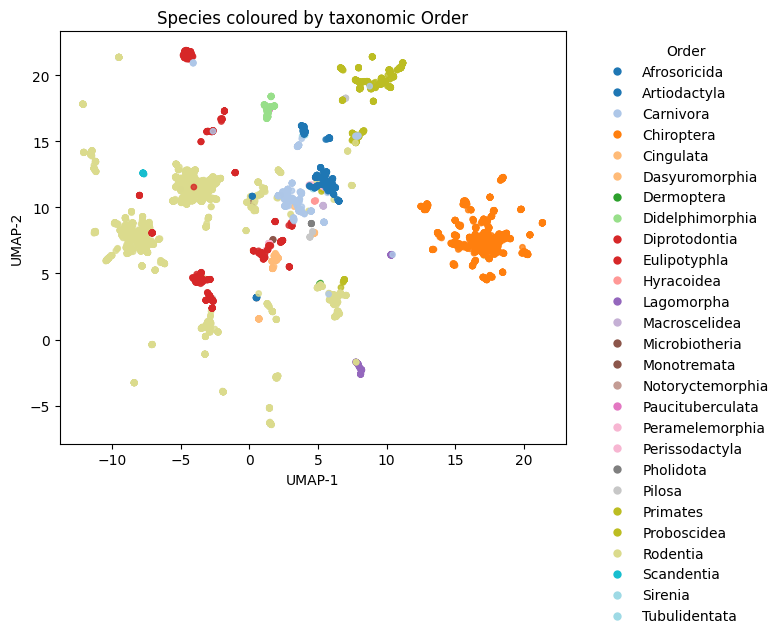

In [ ]:
import umap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.lines as mlines

# Compute UMAP embeddings (assuming 'embeddings' is your high-dimensional data)
reducer = umap.UMAP(random_state=42)
u = reducer.fit_transform(emb)  # define embeddings accordingly

orders = df_small["Order"].fillna("Unknown")
order_codes = orders.astype("category").cat.codes
unique_orders = orders.astype("category").cat.categories

# Build a categorical colormap with enough distinct hues
cmap = mpl.colors.ListedColormap(
    mpl.cm.tab20(np.linspace(0, 1, len(unique_orders)))
)

fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(u[:, 0], u[:, 1],
                c=order_codes,
                cmap=cmap,
                s=15, alpha=.8)

# Legend handles: use mlines.Line2D
handles = [
    mlines.Line2D([0], [0], marker='o', linestyle='',
                  markerfacecolor=cmap(i), markersize=6,
                  markeredgewidth=0, label=ordr)
    for i, ordr in enumerate(unique_orders)
]

ax.legend(handles=handles,
          bbox_to_anchor=(1.05, 1), loc='upper left',
          title="Order", frameon=False)
ax.set_title("Species coloured by taxonomic Order")
ax.set_xlabel("UMAP-1"); ax.set_ylabel("UMAP-2")
plt.tight_layout(); plt.show()


## Print unique orders per cluster with counts

In [ ]:
# Make sure rows are sorted predictably
tmp = df_small.sort_values(["cluster", "Species"])

# Print unique orders per cluster with counts
for c in sorted(tmp["cluster"].unique()):
    print(f"\n— Cluster {c} —")
    counts = tmp[tmp["cluster"] == c]["Order"].value_counts()
    for order, count in counts.items():
        print(f"{order}: {count}")


— Cluster 0 —
Rodentia: 779
Chiroptera: 173
Primates: 80
Diprotodontia: 28
Artiodactyla: 24
Dasyuromorphia: 9
Carnivora: 8
Lagomorpha: 6
Microbiotheria: 2
Eulipotyphla: 2
Peramelemorphia: 1
Macroscelidea: 1
Didelphimorphia: 1

— Cluster 1 —
Primates: 20

— Cluster 2 —
Dasyuromorphia: 62

— Cluster 3 —
Artiodactyla: 5

— Cluster 4 —
Eulipotyphla: 471
Rodentia: 13

— Cluster 5 —
Rodentia: 749

— Cluster 6 —
Primates: 137

— Cluster 7 —
Primates: 66

— Cluster 8 —
Rodentia: 41

— Cluster 9 —
Artiodactyla: 5

— Cluster 10 —
Rodentia: 8

— Cluster 11 —
Carnivora: 6

— Cluster 12 —
Rodentia: 7

— Cluster 13 —
Rodentia: 12

— Cluster 14 —
Chiroptera: 1184

— Cluster 15 —
Rodentia: 113

— Cluster 16 —
Didelphimorphia: 124
Diprotodontia: 33
Paucituberculata: 7
Chiroptera: 1

— Cluster 17 —
Lagomorpha: 39

— Cluster 18 —
Primates: 73

— Cluster 19 —
Lagomorpha: 32

— Cluster 20 —
Carnivora: 21

— Cluster 21 —
Artiodactyla: 19

— Cluster 22 —
Carnivora: 42

— Cluster 23 —
Perissodactyla: 4
Artio

# Calculate Mean Cluster Purity by Order

In [ ]:
import numpy as np

def mean_purity_from_labels(labels, orders):
    purities = []
    for k in np.unique(labels):
        idx     = np.where(labels == k)[0]
        ords    = orders.iloc[idx]
        top     = ords.value_counts().iloc[0]
        purities.append(top / len(ords))
    return np.mean(purities)

orders = df_small["Order"]
print("Mean cluster purity by Order:", mean_purity_from_labels(labels, orders))


Mean cluster purity by Order: 0.9670462607456166


# Families

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
<ipython-input-25-d6475e3022bb>:33: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(); plt.show()


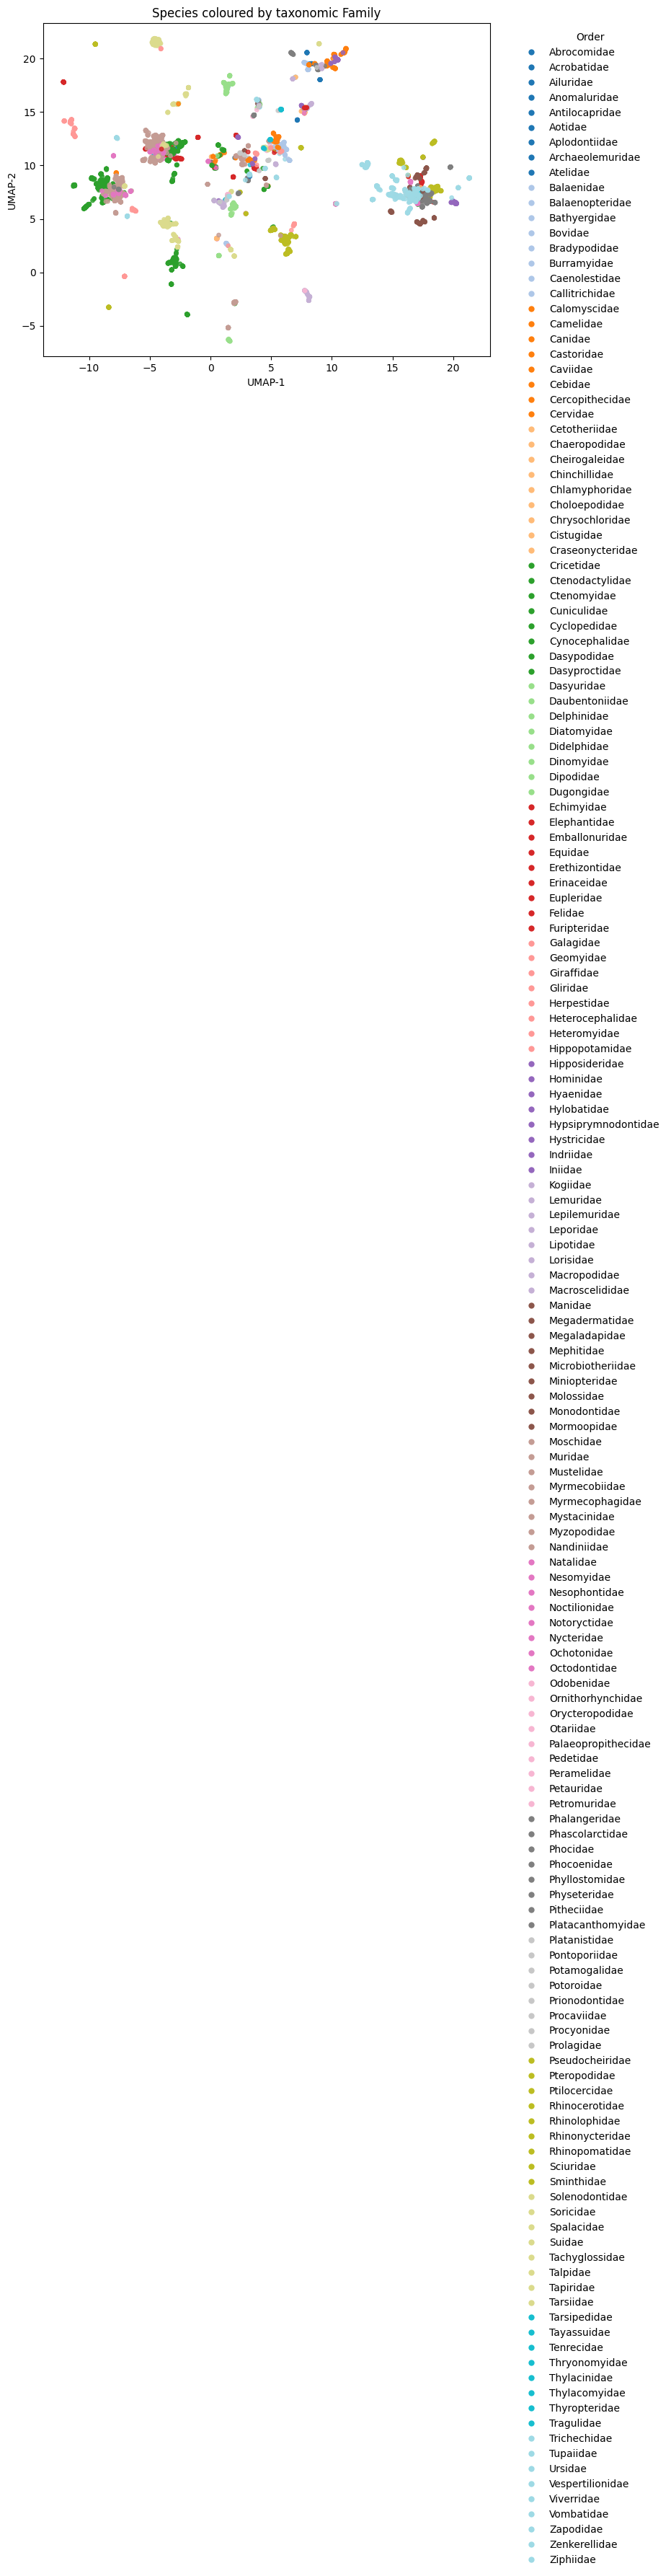

In [ ]:

# Compute UMAP embeddings (assuming 'embeddings' is your high-dimensional data)
reducer = umap.UMAP(random_state=42)
u = reducer.fit_transform(emb)  # define embeddings accordingly

orders = df_small["Family"].fillna("Unknown")
order_codes = orders.astype("category").cat.codes
unique_orders = orders.astype("category").cat.categories

# Build a categorical colormap with enough distinct hues
cmap = mpl.colors.ListedColormap(
    mpl.cm.tab20(np.linspace(0, 1, len(unique_orders)))
)

fig, ax = plt.subplots(figsize=(8, 6))
sc = ax.scatter(u[:, 0], u[:, 1],
                c=order_codes,
                cmap=cmap,
                s=15, alpha=.8)

# Legend handles: use mlines.Line2D
handles = [
    mlines.Line2D([0], [0], marker='o', linestyle='',
                  markerfacecolor=cmap(i), markersize=6,
                  markeredgewidth=0, label=ordr)
    for i, ordr in enumerate(unique_orders)
]

ax.legend(handles=handles,
          bbox_to_anchor=(1.05, 1), loc='upper left',
          title="Order", frameon=False)
ax.set_title("Species coloured by taxonomic Family")
ax.set_xlabel("UMAP-1"); ax.set_ylabel("UMAP-2")
plt.tight_layout(); plt.show()


# Print unique Families per cluster with counts

In [ ]:
# Make sure rows are sorted predictably
tmp = df_small.sort_values(["cluster", "Species"])

# Print unique families per cluster with counts
for c in sorted(tmp["cluster"].unique()):
    print(f"\n— Cluster {c} —")
    counts = tmp[tmp["cluster"] == c]["Family"].value_counts()
    for order, count in counts.items():
        print(f"{order}: {count}")


— Cluster 0 —
Cricetidae: 403
Muridae: 263
Vespertilionidae: 86
Nesomyidae: 45
Phyllostomidae: 34
Cercopithecidae: 24
Sciuridae: 19
Pteropodidae: 18
Bovidae: 16
Molossidae: 14
Zapodidae: 13
Calomyscidae: 12
Atelidae: 12
Macropodidae: 12
Heteromyidae: 9
Dasyuridae: 8
Platacanthomyidae: 8
Petauridae: 8
Cervidae: 8
Pitheciidae: 8
Indriidae: 8
Aotidae: 7
Leporidae: 6
Megadermatidae: 6
Cheirogaleidae: 5
Hominidae: 5
Emballonuridae: 5
Echimyidae: 4
Potoroidae: 4
Callitrichidae: 4
Mustelidae: 3
Hipposideridae: 3
Rhinolophidae: 3
Pseudocheiridae: 3
Rhinonycteridae: 3
Prionodontidae: 2
Soricidae: 2
Microbiotheriidae: 2
Lemuridae: 2
Lepilemuridae: 2
Geomyidae: 2
Felidae: 2
Tarsiidae: 1
Cebidae: 1
Cistugidae: 1
Hypsiprymnodontidae: 1
Macroscelididae: 1
Galagidae: 1
Chaeropodidae: 1
Myrmecobiidae: 1
Pedetidae: 1
Viverridae: 1
Didelphidae: 1

— Cluster 1 —
Galagidae: 18
Lorisidae: 2

— Cluster 2 —
Dasyuridae: 62

— Cluster 3 —
Giraffidae: 5

— Cluster 4 —
Soricidae: 471
Muridae: 13

— Cluster 5 —


# Calculate Mean Cluster Purity by Family

In [ ]:
import numpy as np

def mean_purity_from_labels(labels, families):
    purities = []
    for k in np.unique(labels):
        idx     = np.where(labels == k)[0]
        fams    = families.iloc[idx]
        top     = fams.value_counts().iloc[0]
        purities.append(top / len(fams))
    return np.mean(purities)

families = df_small["Family"]
print("Mean cluster purity by Family:", mean_purity_from_labels(labels, families))


Mean cluster purity by Family: 0.8894517456806396


# Genus

# Print unique Genus per cluster with counts

In [ ]:
# Make sure rows are sorted predictably
tmp = df_small.sort_values(["cluster", "Species"])

# Print unique families per cluster with counts
for c in sorted(tmp["cluster"].unique()):
    print(f"\n— Cluster {c} —")
    counts = tmp[tmp["cluster"] == c]["Genus"].value_counts()
    for order, count in counts.items():
        print(f"{order}: {count}")


— Cluster 0 —
Peromyscus: 82
Thomasomys: 53
Akodon: 42
Myotis: 33
Mus: 29
Reithrodontomys: 27
Neacomys: 24
Pseudomys: 24
Phyllotis: 23
Apodemus: 22
Hylomyscus: 21
Acomys: 21
Calomys: 19
Apomys: 19
Sturnira: 19
Dendromus: 16
Praomys: 13
Calomyscus: 12
Pseudohydromys: 12
Lemniscomys: 10
Abrothrix: 10
Notomys: 10
Pteropus: 10
Petaurus: 8
Steatomys: 8
Zapus: 8
Scotophilus: 8
Mastomys: 8
Alouatta: 8
Necromys: 8
Aotus: 7
Eligmodontia: 7
Typhlomys: 7
Chilomys: 7
Habromys: 7
Rhogeessa: 7
Chiropodomys: 6
Neotamias: 6
Propithecus: 5
Nesoryzomys: 5
Mops: 5
Kerivoula: 5
Pogonomys: 5
Heteromys: 5
Oxymycterus: 5
Rheomys: 4
Papio: 4
Rhagomys: 4
Semnopithecus: 4
Vernaya: 4
Pithecia: 4
Petromyscus: 4
Macaca: 4
Mico: 4
Musseromys: 4
Juliomys: 4
Hybomys: 4
Geoxus: 4
Ateles: 4
Thylogale: 3
Vandeleuria: 3
Tarsomys: 3
Thallomys: 3
Vampyressa: 3
Chiruromys: 3
Auliscomys: 3
Toromys: 3
Eozapus: 3
Dermanura: 3
Coccymys: 3
Cnephaeus: 3
Megadontomys: 3
Macrotarsomys: 3
Micromys: 3
Molossus: 3
Ozimops: 3
Potorous

# Calculate Mean Cluster Purity by Genus

In [ ]:
import numpy as np

def mean_purity_from_labels(labels, genuses):
    purities = []
    for k in np.unique(labels):
        idx     = np.where(labels == k)[0]
        gens    = genuses.iloc[idx]
        top     = gens.value_counts().iloc[0]
        purities.append(top / len(gens))
    return np.mean(purities)

genuses = df_small["Genus"]
print("Mean cluster purity by Genus:", mean_purity_from_labels(labels, genuses))

Mean cluster purity by Genus: 0.6345381837155634


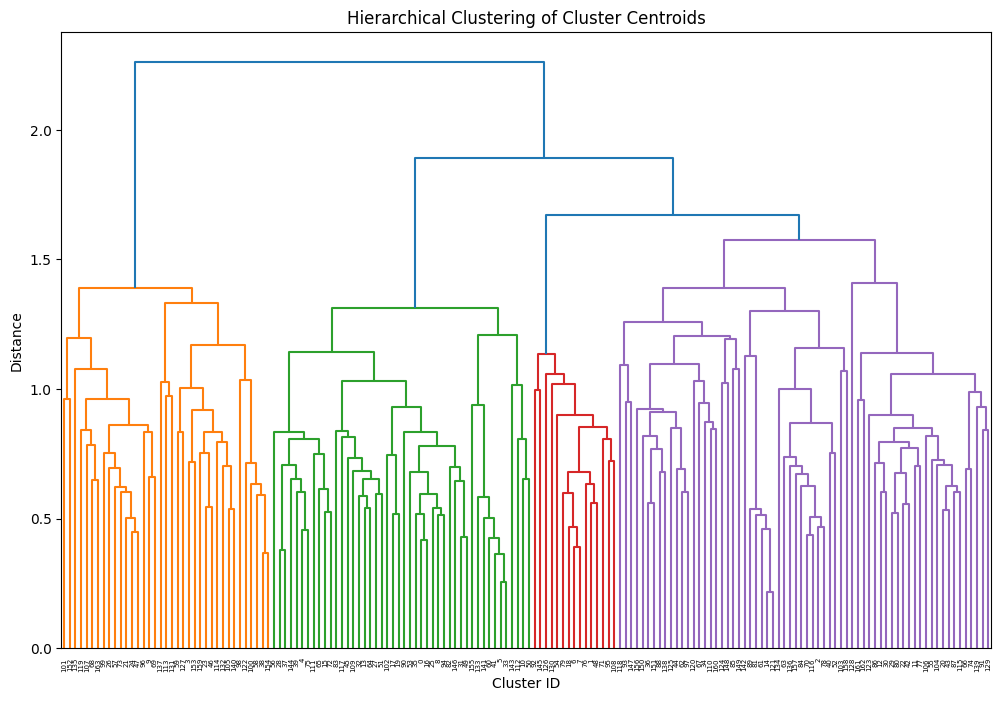

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Get centroids of your current clusters
cluster_centroids = np.array([emb[labels == i].mean(axis=0) for i in np.unique(labels)])

# Perform hierarchical clustering on centroids
Z = linkage(cluster_centroids, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 8))
dendrogram(Z)
plt.title('Hierarchical Clustering of Cluster Centroids')
plt.xlabel('Cluster ID')
plt.ylabel('Distance')
plt.show()

In [ ]:
import networkx as nx
from scipy.cluster.hierarchy import fcluster

def build_ontology_from_clusters(labels, embeddings, df_small, dendrogram_Z):
    # Create a directed graph for the ontology
    G = nx.DiGraph()

    # Level 1: Add species nodes (lowest level)
    for idx, row in df_small.iterrows():
        species_id = f"species_{idx}"
        G.add_node(species_id,
                   name=row['Species'],
                   common_name=row['CommonName'],
                   type='Species',
                   cluster=labels[idx])

    # Level 2: Add cluster nodes
    unique_clusters = np.unique(labels)
    cluster_to_centroid = {}
    for cluster_id in unique_clusters:
        cluster_node = f"cluster_{cluster_id}"
        indices = np.where(labels == cluster_id)[0]

        # Get dominant taxonomy
        dom_genus = df_small.iloc[indices]['Genus'].value_counts().idxmax()
        dom_family = df_small.iloc[indices]['Family'].value_counts().idxmax()
        dom_order = df_small.iloc[indices]['Order'].value_counts().idxmax()

        # Calculate purity
        genus_purity = df_small.iloc[indices]['Genus'].value_counts().max() / len(indices)
        family_purity = df_small.iloc[indices]['Family'].value_counts().max() / len(indices)
        order_purity = df_small.iloc[indices]['Order'].value_counts().max() / len(indices)

        # Add the cluster node
        G.add_node(cluster_node,
                   type='Cluster',
                   dominant_genus=dom_genus,
                   dominant_family=dom_family,
                   dominant_order=dom_order,
                   genus_purity=genus_purity,
                   family_purity=family_purity,
                   order_purity=order_purity,
                   size=len(indices))

        # Connect species to clusters
        for idx in indices:
            species_id = f"species_{idx}"
            G.add_edge(species_id, cluster_node)

        # Store centroid for higher-level clustering
        cluster_to_centroid[cluster_id] = embeddings[indices].mean(axis=0)

    # Level 3-5: Generate hierarchical groupings at multiple levels
    for level_threshold in [5, 10, 15]:  # Different distance thresholds
        level_labels = fcluster(dendrogram_Z, level_threshold, criterion='distance')

        # Add higher-level nodes
        for super_cluster_id in np.unique(level_labels):
            super_node = f"super_cluster_L{level_threshold}_{super_cluster_id}"

            # Get clusters in this super-cluster
            cluster_indices = [i for i, l in enumerate(level_labels) if l == super_cluster_id]
            cluster_ids = [unique_clusters[i] for i in cluster_indices]

            # Get dominant taxonomy of this super-cluster
            all_indices = []
            for c in cluster_ids:
                all_indices.extend(np.where(labels == c)[0])

            if all_indices:
                dom_family = df_small.iloc[all_indices]['Family'].value_counts().idxmax()
                dom_order = df_small.iloc[all_indices]['Order'].value_counts().idxmax()

                # Add super-cluster node
                G.add_node(super_node,
                           type=f'SuperCluster_L{level_threshold}',
                           dominant_family=dom_family,
                           dominant_order=dom_order,
                           size=len(all_indices))

                # Connect clusters to super-cluster
                for c in cluster_ids:
                    G.add_edge(f"cluster_{c}", super_node)

    # Level 6: Add biological taxonomy nodes
    # Add Genus level
    for genus in df_small['Genus'].dropna().unique():
        G.add_node(f"genus_{genus}", name=genus, type='Genus')

    # Add Family level
    for family in df_small['Family'].dropna().unique():
        G.add_node(f"family_{family}", name=family, type='Family')

    # Add Order level
    for order in df_small['Order'].dropna().unique():
        G.add_node(f"order_{order}", name=order, type='Order')

    # Add Subclass level
    for subclass in df_small['Subclass'].dropna().unique():
        G.add_node(f"subclass_{subclass}", name=subclass, type='Subclass')

    # Connect biological taxonomy
    for idx, row in df_small.iterrows():
        species_id = f"species_{idx}"

        if pd.notna(row['Genus']):
            genus_id = f"genus_{row['Genus']}"
            G.add_edge(species_id, genus_id)

            if pd.notna(row['Family']):
                family_id = f"family_{row['Family']}"
                G.add_edge(genus_id, family_id)

                if pd.notna(row['Order']):
                    order_id = f"order_{row['Order']}"
                    G.add_edge(family_id, order_id)

                    if pd.notna(row['Subclass']):
                        subclass_id = f"subclass_{row['Subclass']}"
                        G.add_edge(order_id, subclass_id)

    return G

In [ ]:
def visualize_ontology_subgraph(G, node_type=None, max_nodes=50):
    """
    Visualize a subgraph of the ontology, filtered by node type if specified.
    """
    if node_type:
        nodes = [n for n, d in G.nodes(data=True) if d.get('type') == node_type]
        nodes = nodes[:max_nodes]  # Limit number of nodes for visualization
        H = G.subgraph(nodes)
    else:
        # Just take a sample
        nodes = list(G.nodes())[:max_nodes]
        H = G.subgraph(nodes)

    plt.figure(figsize=(15, 12))
    pos = nx.spring_layout(H, seed=42)

    # Color by node type
    node_colors = []
    for node in H.nodes():
        node_type = G.nodes[node].get('type', 'Unknown')
        if node_type == 'Species':
            node_colors.append('skyblue')
        elif node_type == 'Cluster':
            node_colors.append('lightgreen')
        elif 'SuperCluster' in str(node_type):
            node_colors.append('orange')
        elif node_type == 'Genus':
            node_colors.append('pink')
        elif node_type == 'Family':
            node_colors.append('purple')
        elif node_type == 'Order':
            node_colors.append('red')
        else:
            node_colors.append('gray')

    nx.draw(H, pos, with_labels=True, node_color=node_colors,
            node_size=500, font_size=8, arrows=True)

    plt.title(f"Ontology Graph - {node_type if node_type else 'Sample'}")
    plt.tight_layout()
    plt.show()

In [ ]:
def export_ontology_to_owl(G, filename="mammal_ontology.owl"):
    """
    Export the NetworkX graph as an OWL ontology file
    """
    from owlready2 import get_ontology, Thing, types

    # Create a new ontology
    onto = get_ontology("http://example.org/mammal-ontology.owl")

    with onto:
        # Define classes
        class TaxonomicEntity(Thing): pass
        class Species(TaxonomicEntity): pass
        class Genus(TaxonomicEntity): pass
        class Family(TaxonomicEntity): pass
        class Order(TaxonomicEntity): pass
        class Subclass(TaxonomicEntity): pass
        class Cluster(TaxonomicEntity): pass
        class SuperCluster(TaxonomicEntity): pass

        # Define properties
        class has_member(SuperCluster >> Cluster): pass
        class belongs_to(Cluster >> SuperCluster): inverse_property = has_member

        class contains_species(Cluster >> Species): pass
        class grouped_in(Species >> Cluster): inverse_property = contains_species

        class has_taxonomic_rank(Species >> Genus): pass

        # Add instances from the graph
        for node, data in G.nodes(data=True):
            node_type = data.get('type', '')
            name = data.get('name', node)

            if node_type == 'Species':
                instance = Species(name.replace(' ', '_'))
                instance.label = name
                if 'common_name' in data:
                    instance.comment = data['common_name']

            elif node_type == 'Genus':
                instance = Genus(name.replace(' ', '_'))
                instance.label = name

            elif node_type == 'Family':
                instance = Family(name.replace(' ', '_'))
                instance.label = name

            elif node_type == 'Order':
                instance = Order(name.replace(' ', '_'))
                instance.label = name

            elif node_type == 'Subclass':
                instance = Subclass(name.replace(' ', '_'))
                instance.label = name

            elif node_type == 'Cluster':
                instance = Cluster(f"cluster_{node.split('_')[-1]}")
                if 'dominant_genus' in data:
                    instance.comment = f"Dominant genus: {data['dominant_genus']}"

            elif 'SuperCluster' in node_type:
                instance = SuperCluster(f"supercluster_{node.split('_')[-1]}")
                if 'dominant_family' in data:
                    instance.comment = f"Dominant family: {data['dominant_family']}"

        # Add relationships
        for source, target in G.edges():
            source_type = G.nodes[source].get('type', '')
            target_type = G.nodes[target].get('type', '')

            source_name = G.nodes[source].get('name', source)
            target_name = G.nodes[target].get('name', target)

            source_instance = onto.search_one(label=source_name)
            target_instance = onto.search_one(label=target_name)

            if source_instance and target_instance:
                if source_type == 'Species' and target_type == 'Cluster':
                    source_instance.grouped_in.append(target_instance)
                elif source_type == 'Cluster' and target_type.startswith('SuperCluster'):
                    source_instance.belongs_to.append(target_instance)
                elif source_type == 'Species' and target_type == 'Genus':
                    source_instance.has_taxonomic_rank.append(target_instance)

    # Save the ontology
    onto.save(file=filename, format="rdfxml")
    return onto

In [ ]:
def apply_renormalization(embeddings, labels, levels=3, scaling_factor=2):
    """
    Apply renormalization group theory concepts to create a hierarchy
    """
    results = []
    current_labels = labels.copy()
    current_embeddings = embeddings.copy()

    for level in range(levels):
        # Record current state
        results.append((current_labels.copy(), current_embeddings.copy()))

        # Coarse-grain: Cluster the centroids
        unique_labels = np.unique(current_labels)
        centroids = np.array([
            current_embeddings[current_labels == label].mean(axis=0)
            for label in unique_labels
        ])

        # Reduce number of clusters at each level
        n_clusters = max(2, len(unique_labels) // scaling_factor)

        # Apply agglomerative clustering to centroids
        from sklearn.cluster import AgglomerativeClustering
        agg = AgglomerativeClustering(n_clusters=n_clusters)
        new_labels = agg.fit_predict(centroids)

        # Map old labels to new ones
        label_map = {old: new for old, new in zip(unique_labels, new_labels)}
        mapped_labels = np.array([label_map[label] for label in current_labels])

        # Update for next iteration
        current_labels = mapped_labels

        # Update embeddings (optional): replace each point with its cluster centroid
        for label in np.unique(current_labels):
            mask = current_labels == label
            current_embeddings[mask] = current_embeddings[mask].mean(axis=0)

    return results

In [ ]:
def identify_fixed_points(renormalization_results, df_small):
    """
    Identify stable taxonomic groups that persist across renormalization levels
    """
    fixed_points = []

    for level_idx in range(1, len(renormalization_results)):
        prev_labels, _ = renormalization_results[level_idx-1]
        curr_labels, _ = renormalization_results[level_idx]

        # For each cluster in current level
        for cluster in np.unique(curr_labels):
            indices = np.where(curr_labels == cluster)[0]

            # Get taxonomic information for this cluster
            orders = df_small.iloc[indices]['Order'].value_counts()
            families = df_small.iloc[indices]['Family'].value_counts()

            # Check if this cluster has high taxonomic purity
            if len(orders) > 0 and orders.iloc[0] / orders.sum() > 0.9:
                fixed_points.append({
                    'level': level_idx,
                    'cluster': cluster,
                    'taxonomic_unit': 'Order',
                    'dominant_value': orders.index[0],
                    'purity': orders.iloc[0] / orders.sum(),
                    'size': len(indices)
                })

            if len(families) > 0 and families.iloc[0] / families.sum() > 0.9:
                fixed_points.append({
                    'level': level_idx,
                    'cluster': cluster,
                    'taxonomic_unit': 'Family',
                    'dominant_value': families.index[0],
                    'purity': families.iloc[0] / families.sum(),
                    'size': len(indices)
                })

    return pd.DataFrame(fixed_points)

<ipython-input-37-dd76caa5c999>:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


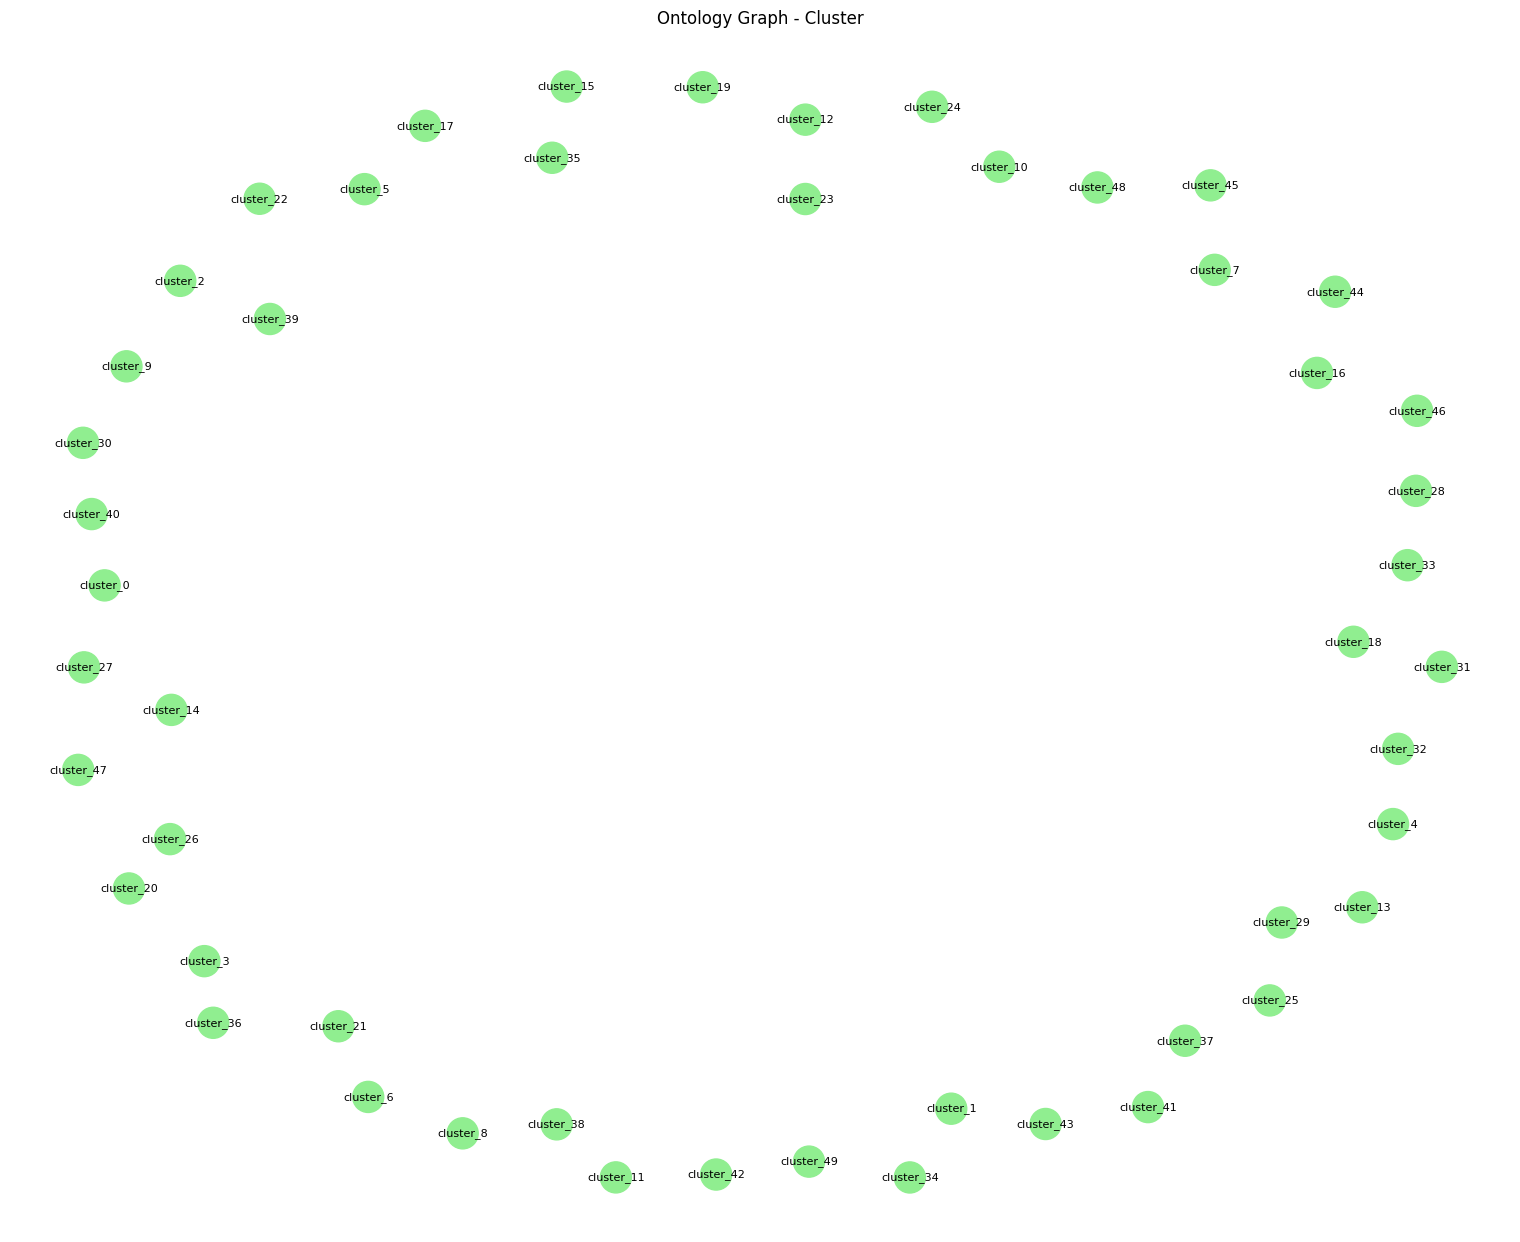

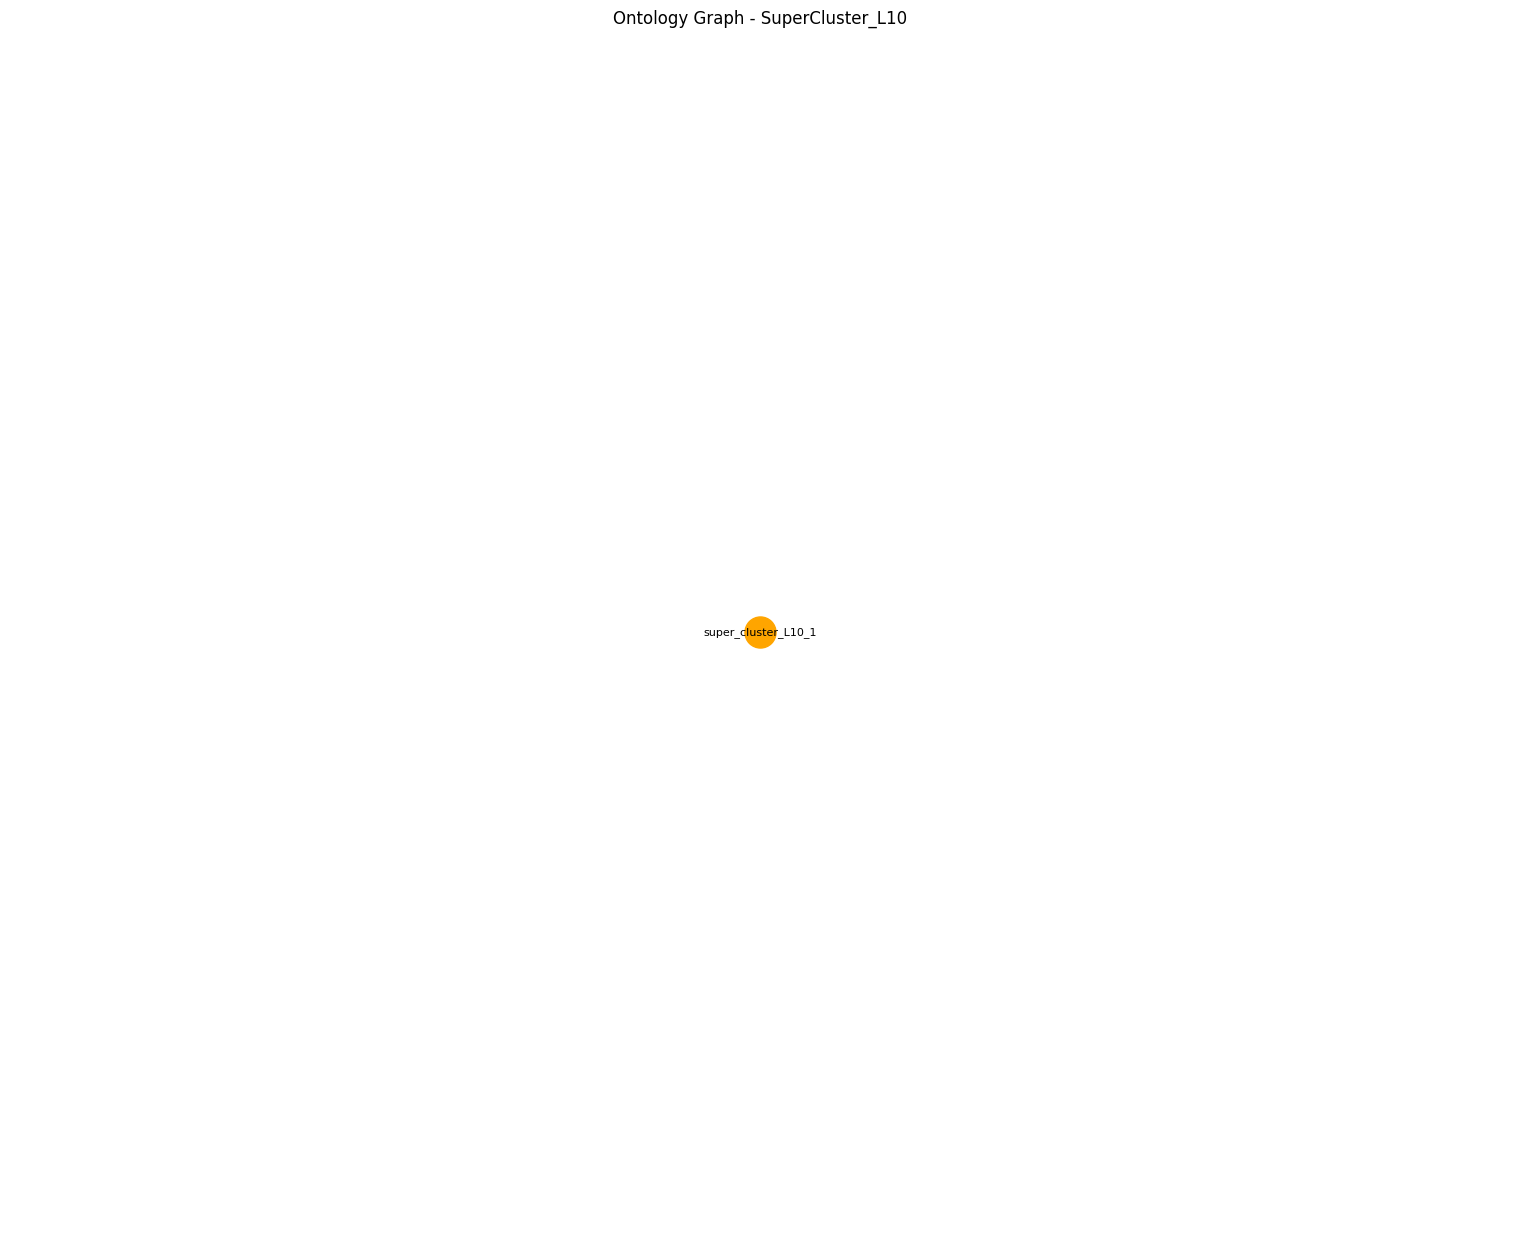

In [ ]:
# Build the ontology
mammal_ontology = build_ontology_from_clusters(labels, emb, df_small, Z)

# Visualize key components
visualize_ontology_subgraph(mammal_ontology, node_type='Cluster')
visualize_ontology_subgraph(mammal_ontology, node_type='SuperCluster_L10')

# Export to standard format
owl_onto = export_ontology_to_owl(mammal_ontology)

In [ ]:
!pip install owlready2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.3/27.3 MB 98.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for owlready2: filename=owlready2-0.47-cp311-cp311-linux_x86_64.whl size=24520975 sha256=cff6a987eeb600a19ad89c44f75830f11dace75ae4a819e31dde2edc7695b6cf
  Stored in directory: /root/.cache/pip/wheels/25/9a/a3/fb1ac6339caa859c8bb18d685736168b0b51d851af13d81d52
Successfully built owlready2


level  taxonomic_unit
1      Family            56
       Order             68
2      Family            34
       Order             36
3      Family            14
       Order             15
dtype: int64


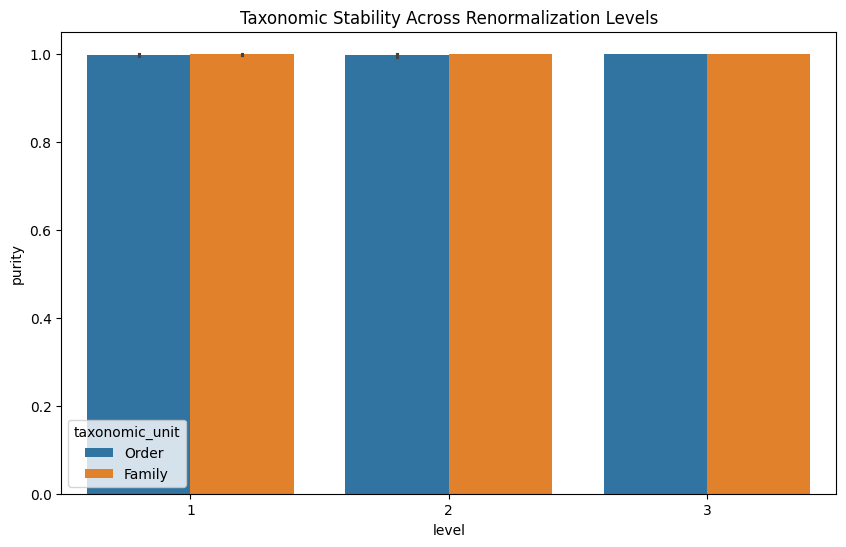

In [ ]:
import seaborn as sns
# Apply renormalization
rg_results = apply_renormalization(emb, labels, levels=4)

# Find fixed points
fixed_df = identify_fixed_points(rg_results, df_small)
print(fixed_df.groupby(['level', 'taxonomic_unit']).size())

# Visualize fixed points
plt.figure(figsize=(10, 6))
sns.barplot(data=fixed_df, x='level', y='purity', hue='taxonomic_unit')
plt.title('Taxonomic Stability Across Renormalization Levels')
plt.show()

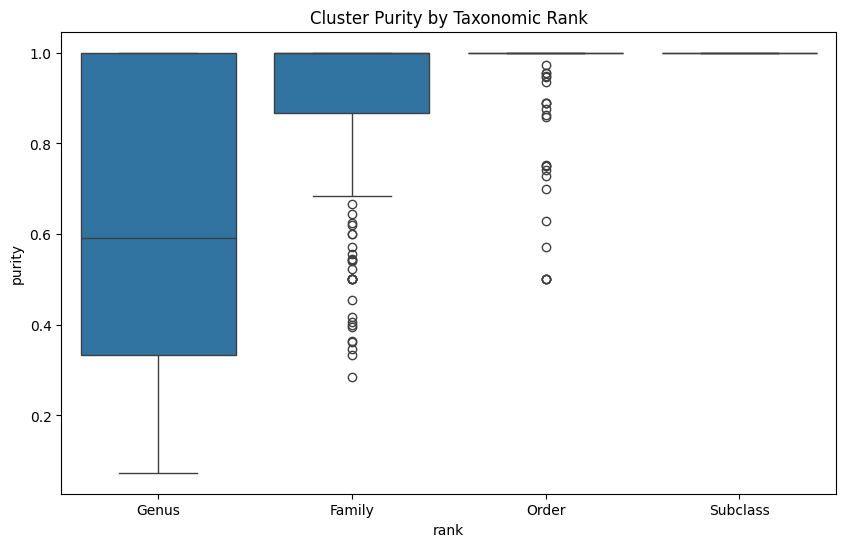

In [ ]:
# Count alignment between clusters and taxonomic ranks
alignment_df = []
for cluster in np.unique(labels):
    indices = np.where(labels == cluster)[0]
    cluster_data = df_small.iloc[indices]

    for rank in ['Genus', 'Family', 'Order', 'Subclass']:
        dominant = cluster_data[rank].value_counts().idxmax()
        count = cluster_data[rank].value_counts().max()
        purity = count / len(indices)

        alignment_df.append({
            'cluster': cluster,
            'rank': rank,
            'dominant': dominant,
            'purity': purity,
            'size': len(indices)
        })

alignment_df = pd.DataFrame(alignment_df)

# Visualize alignment
plt.figure(figsize=(10, 6))
sns.boxplot(data=alignment_df, x='rank', y='purity')
plt.title('Cluster Purity by Taxonomic Rank')
plt.show()
